In [1]:
from qiskit import *
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np

In [2]:
def paulidecompos(Matriz):
    x,y=Matriz.shape
    sigmax=sp.Matrix([[0,1],[1,0]])
    sigmay=sp.Matrix([[0,-sp.I],[sp.I,0]])
    sigmaz=sp.Matrix([[1,0],[0,-1]])
    Identity=sp.Matrix([[1,0],[0,1]])
    if x==y:
        II=sp.kronecker_product(Identity,Identity)
        IZ=sp.kronecker_product(Identity,sigmaz)
        ZZ=sp.kronecker_product(sigmaz,sigmaz)
        XX=sp.kronecker_product(sigmax,sigmax)
        YY=sp.kronecker_product(sigmay,sigmay)
        ZI=sp.kronecker_product(sigmaz,Identity)
        pauli=[II,ZZ,XX,YY,IZ,ZI]
        tags=['II','ZZ','XX','YY','IZ',"ZI"]
        elements=sp.symbols('a0:6')
        general_m=sp.zeros(x)
    else:
        print('The input is not a square matrix')
    for i in range(0,len(tags)):
        general_m+=pauli[i]*elements[i]
    decomposition=sp.solve(general_m-Matriz)
    coeff={}
    for i in range(len(tags)):
        coeff[tags[i]]=decomposition[elements[i]]
    return coeff

In [3]:
Matriz=sp.Matrix([[1.67,0.84-1.64j,1.51-1.06j,-0.49-1.7j],[0.84+1.64j,0.35,0.63+0.06j,0.12+0.7j],[1.51+1.06j,0.63-0.06j,-0.57,-0.07-0.03j],[-0.49+1.7j,0.12-0.7j,-0.07+0.3j,0.63]])
Matriz

Matrix([
[         1.67, 0.84 - 1.64*I, 1.51 - 1.06*I,  -0.49 - 1.7*I],
[0.84 + 1.64*I,          0.35, 0.63 + 0.06*I,   0.12 + 0.7*I],
[1.51 + 1.06*I, 0.63 - 0.06*I,         -0.57, -0.07 - 0.03*I],
[-0.49 + 1.7*I,  0.12 - 0.7*I, -0.07 + 0.3*I,           0.63]])

In [4]:
Matriz.eigenvals()

{4.24860481186118 + 0.0170622308761805*I: 1,
 1.10419676279123 - 0.0460192069800934*I: 1,
 -2.23061681567251 + 0.00874925714750745*I: 1,
 -1.0421847589799 + 0.0202077189564055*I: 1}

In [5]:
#coeff=paulidecompos(Matriz)
coeff={'II':0.2,'ZZ':0.2,'YY':-1,'XX':1,'IZ':0,'ZI':0}
coeff

{'II': 0.2, 'ZZ': 0.2, 'YY': -1, 'XX': 1, 'IZ': 0, 'ZI': 0}

In [6]:
sigmax=sp.Matrix([[0,1],[1,0]])
sigmay=sp.Matrix([[0,-sp.I],[sp.I,0]])
sigmaz=sp.Matrix([[1,0],[0,-1]])
sigmax.eigenvals()

{-1: 1, 1: 1}

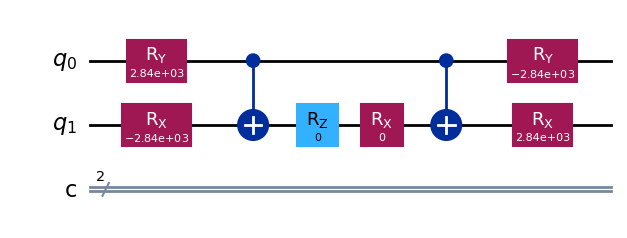

In [7]:
circuit=QuantumCircuit(2,2)
q = circuit.qregs[0]
circuit.ry(284065/100,q[0])
circuit.rx(-284065/100,q[1])
circuit.cx(q[0], q[1])
circuit.rz(0, q[1])
circuit.rx(0, q[1])
circuit.cx(q[0], q[1])
circuit.ry(-284065/100,q[0])
circuit.rx(284065/100,q[1])
circuit.draw('mpl')

In [8]:
def ansatz(circuit, theta,theta2):
    q = circuit.qregs[0]
    circuit.ry(284065/100,q[0])
    circuit.rx(-284065/100,q[1])
    circuit.cx(q[0], q[1])
    circuit.rz(theta, q[1])
    circuit.rx(theta2, q[1])
    circuit.cx(q[0], q[1])
    circuit.ry(-284065/100,q[0])
    circuit.rx(284065/100,q[1])
    return circuit

In [9]:
def two_qubit_vqe(theta,theta2, basis):
    """
    Notice this function is lacking some of the combinations
    """
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # implement the ansate in the circuit
    circuit = ansatz(circuit, theta,theta2)
    # measurement
    if basis == 'ZZ':
        circuit.measure(q, c)
        # Notice I'm not using the appropiate gates according to the microsoft link
        # if you also don't explain why
    elif basis == 'XX':
        circuit.h( q[0])
        circuit.h( q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif basis == 'YY':
        circuit.sdg( q[0])
        circuit.sdg( q[1])
        circuit.h( q[0])
        circuit.h( q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif basis == 'IZ':
        circuit.measure(q, c)
    elif basis == 'ZI':
        circuit.measure(q, c)
    else:
        raise ValueError('Not a valid pauli basis, input should be X,Y or Z, we excluded I because no circuit is needed')
    return circuit

In [10]:
from qiskit_aer import AerSimulator

simulator=AerSimulator()

In [11]:
def get_expectation(theta,theta2, basis):

    if basis == 'II':
        return 1
    else:
        circuit = two_qubit_vqe(theta,theta2, basis)

    simulator=AerSimulator()
    job = simulator.run(circuit, shots=1_000)
    result = job.result()
    counts = result.get_counts()
    expected_value = 0
    for event in counts:
        pm = 1
        if event == '01':
            pm = -1
        if event == '10':
            pm = -1
        expected_value += pm * counts[event] / 1_000

    return expected_value

In [12]:
def vqe_ground(theta,theta2):
    sum_=0
    tags=['II','IZ','ZZ','XX','YY','ZI']
    for i in tags:
        sum_+=coeff[i]*get_expectation(theta,theta2, i)
    return sum_

In [13]:
theta=np.arange(-2*np.pi,2*np.pi,np.pi/10)
theta2=np.arange(-2*np.pi,2*np.pi,np.pi/10)
xv, yv = np.meshgrid(theta, theta2)
E_0=np.zeros(xv.shape)
for l,i in enumerate(theta):
    for k,j in enumerate(theta2):
        E_0[l,k] = vqe_ground(i,j)

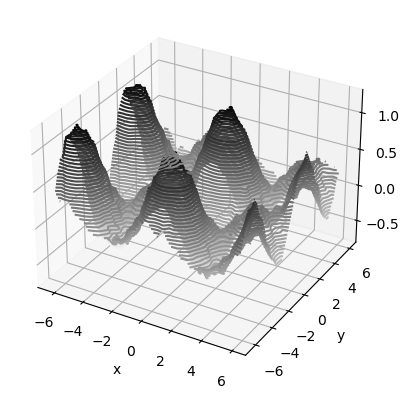

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(xv, yv, E_0, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

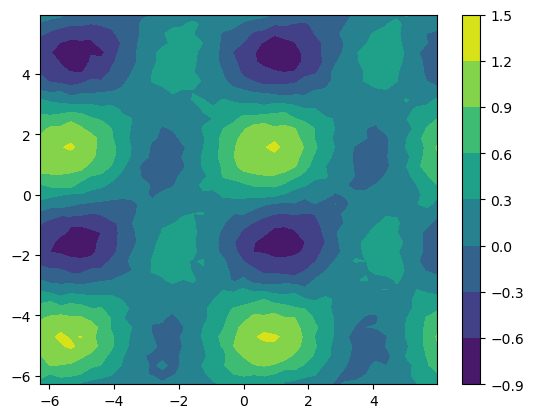

In [15]:
plt.contourf(xv,yv,E_0)
plt.colorbar()

In [16]:
np.min(E_0)

-0.7703999999999998

In [17]:
np.linalg.eigvals(np.array(Matriz.tolist(),dtype=np.complex64))

array([ 4.248605 +0.01706223j, -2.2306168+0.00874926j,
        1.1041968-0.04601921j, -1.0421847+0.02020772j], dtype=complex64)

In [18]:
def test_paulidecompos_valid():
    Matriz = sp.Matrix([[1, 0], [0, 1]])
    coeff = paulidecompos(Matriz)
    assert coeff == {'II': 1.0, 'ZZ': 0.0, 'XX': 0.0, 'YY': 0.0, 'IZ': 0.0, 'ZI': 0.0}

def test_paulidecompos_invalid():
    Matriz = sp.Matrix([[1, 2, 3], [4, 5, 6]])
    coeff = paulidecompos(Matriz)
    assert coeff == None 

In [19]:
def test_vqe_ground():
    theta = 0.0
    theta2 = 0.0
    result = vqe_ground(theta, theta2)
    assert abs(result + 0.2) < 1e-10 

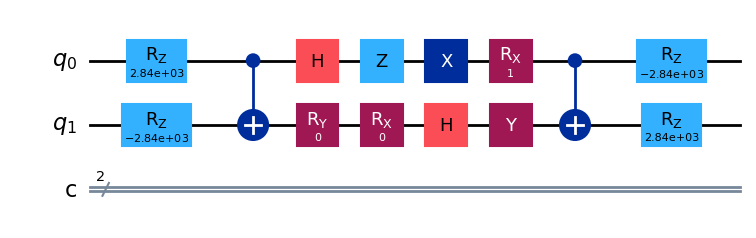

In [20]:
circuit=QuantumCircuit(2,2)
q = circuit.qregs[0]
circuit.rz(284065/100,q[0])
circuit.rz(-284065/100,q[1])
circuit.cx(q[0], q[1])
circuit.h(0)
circuit.ry(0, q[1])
circuit.rx(0, q[1])
circuit.h(1)
circuit.z(0)
circuit.x(0)
circuit.rx(1, q[0])
circuit.y(1)
circuit.cx(q[0], q[1])
circuit.rz(-284065/100,q[0])
circuit.rz(284065/100,q[1])
circuit.draw('mpl')

In [21]:
def ansatz(circuit, theta,theta2):
    q = circuit.qregs[0]
    circuit.rz(284065/100,q[0])
    circuit.rz(-284065/100,q[1])
    circuit.cx(q[0], q[1])
    circuit.h(0)
    circuit.ry(0, q[1])
    circuit.rx(0, q[1])
    circuit.h(1)
    circuit.z(0)
    circuit.x(0)
    circuit.rx(1, q[0])
    circuit.y(1)
    circuit.cx(q[0], q[1])
    circuit.rz(-284065/100,q[0])
    circuit.rz(284065/100,q[1])
    return circuit

In [22]:
def two_qubit_vqe(theta,theta2, basis):
    """
    Notice this function is lacking some of the combinations
    """
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # implement the ansate in the circuit
    circuit = ansatz(circuit, theta,theta2)
    # measurement
    if basis == 'ZZ':
        circuit.measure(q, c)
        # Notice I'm not using the appropiate gates according to the microsoft link
        # if you also don't explain why
    elif basis == 'XX':
        circuit.h( q[0])
        circuit.h( q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif basis == 'YY':
        circuit.sdg( q[0])
        circuit.sdg( q[1])
        circuit.h( q[0])
        circuit.h( q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif basis == 'IZ':
        circuit.measure(q, c)
    elif basis == 'ZI':
        circuit.measure(q, c)
    else:
        raise ValueError('Not a valid pauli basis, input should be X,Y or Z, we excluded I because no circuit is needed')
    return circuit

In [23]:
from qiskit_aer import AerSimulator

simulator=AerSimulator()

In [24]:
def get_expectation(theta,theta2, basis):

    if basis == 'II':
        return 1
    else:
        circuit = two_qubit_vqe(theta,theta2, basis)

    simulator=AerSimulator()
    job = simulator.run(circuit, shots=1_000)
    result = job.result()
    counts = result.get_counts()
    expected_value = 0
    for event in counts:
        pm = 1
        if event == '01':
            pm = -1
        if event == '10':
            pm = -1
        expected_value += pm * counts[event] / 1_000

    return expected_value

In [25]:
def vqe_ground(theta,theta2):
    sum_=0
    tags=['II','IZ','ZZ','XX','YY','ZI']
    for i in tags:
        sum_+=coeff[i]*get_expectation(theta,theta2, i)
    return sum_

In [26]:
theta=np.arange(-2*np.pi,2*np.pi,np.pi/10)
theta2=np.arange(-2*np.pi,2*np.pi,np.pi/10)
xv, yv = np.meshgrid(theta, theta2)
E_0=np.zeros(xv.shape)
for l,i in enumerate(theta):
    for k,j in enumerate(theta2):
        E_0[l,k] = vqe_ground(i,j)

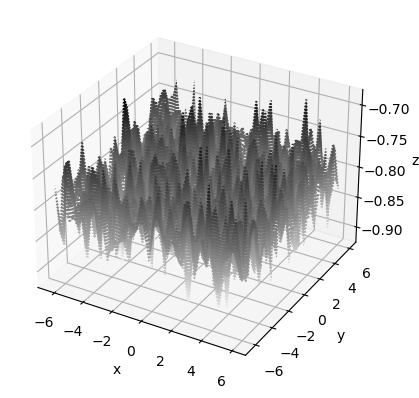

In [27]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(xv, yv, E_0, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

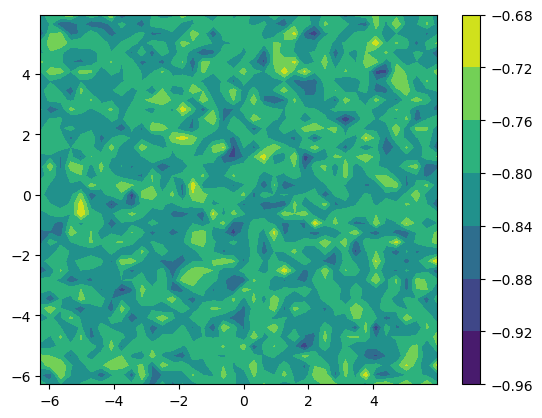

In [28]:
plt.contourf(xv,yv,E_0)
plt.colorbar()

In [29]:
np.min(E_0)

-0.9207999999999998

In [30]:
np.linalg.eigvals(np.array(Matriz.tolist(),dtype=np.complex64))

array([ 4.248605 +0.01706223j, -2.2306168+0.00874926j,
        1.1041968-0.04601921j, -1.0421847+0.02020772j], dtype=complex64)

In [31]:
def test_paulidecompos_valid():
    Matriz = sp.Matrix([[1, 0], [0, 1]])
    coeff = paulidecompos(Matriz)
    assert coeff == {'II': 1.0, 'ZZ': 0.0, 'XX': 0.0, 'YY': 0.0, 'IZ': 0.0, 'ZI': 0.0}

def test_paulidecompos_invalid():
    Matriz = sp.Matrix([[1, 2, 3], [4, 5, 6]])
    coeff = paulidecompos(Matriz)
    assert coeff == None 

In [32]:
def test_vqe_ground():
    theta = 0.0
    theta2 = 0.0
    result = vqe_ground(theta, theta2)
    assert abs(result + 0.2) < 1e-10 